In [1]:
import geopandas as gpd
import pandas as pd

import folium
from folium.plugins import HeatMap

import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib import colors

import seaborn as sns

In [2]:
property_df = pd.read_parquet("../../data/raw/property_details_w_distances.parquet")
suburbs_gdf = gpd.read_parquet('../../data/curated/suburb_shapefile_w_postcodes.parquet')

property_gdf = gpd.GeoDataFrame(
    property_df, geometry=gpd.points_from_xy(property_df.longitude, property_df.latitude), crs="EPSG:4326"
)

# Reproject both GeoDataFrames to the same CRS (WGS84 is what Folium uses)
suburbs_gdf = suburbs_gdf.to_crs(epsg=4326)
property_gdf = property_gdf.to_crs(epsg=4326)

# Check if everything loaded correctly
property_gdf.head()
suburbs_gdf.head()

LC_PLY_PID          LOC_PID  DT_CREATE    LOC_NAME          LOC_CLASS  \
0  lcp-ejVyte1DxXx  locb0dcb52a6b55 2023-06-26    Abbeyard  Gazetted Locality   
1  lcp386f2bcf9bce  locb9872f35df41 2021-06-24  Abbotsford  Gazetted Locality   
2  lcprFRP2-cPMfr5  loc8123ed12ea8d 2023-03-21  Aberfeldie  Gazetted Locality   
3  lcpj3KHi-vakgFj  loc1eb4a229104a 2023-12-10   Aberfeldy  Gazetted Locality   
4  lcpoO-hq-yZZASg  locb17be87767e1 2023-12-10     Acheron  Gazetted Locality   

  STATE                                           geometry postcode  
0   VIC  POLYGON ((146.65061 -36.94496, 146.68449 -36.9...     3737  
1   VIC  POLYGON ((144.99137 -37.80959, 144.99254 -37.8...     3067  
2   VIC  POLYGON ((144.88854 -37.75546, 144.88854 -37.7...     3040  
3   VIC  POLYGON ((146.35535 -37.69944, 146.35751 -37.6...     3825  
4   VIC  POLYGON ((145.638 -37.28417, 145.64233 -37.279...     3714

In [3]:
# Calculate centroid of the properties to center the map
centroid = property_gdf.geometry.centroid
center_lat = centroid.y.mean()
center_lon = centroid.x.mean()

# Create a base Folium map centered on the mean coordinates
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Prepare the heatmap data: [latitude, longitude, price]
heat_data = [[row['geometry'].y, row['geometry'].x, row['price']] for index, row in property_gdf.iterrows()]

# Add the heatmap to the folium map
HeatMap(heat_data, radius=10, blur=15, max_zoom=10).add_to(m)

m

/tmp/ipykernel_28516/2743098247.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = property_gdf.geometry.centroid


In [4]:
# Group properties by postcode and calculate various statistics
property_counts = property_df.groupby('postcode').size().reset_index(name='property_count')
average_price = property_df.groupby('postcode')['price'].mean().reset_index(name='avg_price')
distance_to_closest_supermarket = property_df.groupby('postcode')['distance_to_closest_supermarket'].mean().reset_index(name='distance_to_closest_supermarket')
avg_distance_to_school = property_df.groupby('postcode')['nearby_schools'].mean().reset_index(name='distance_to_closest_school')
avg_distance_to_ptv = property_df.groupby('postcode')[['distance_to_closest_train', 'distance_to_closest_bus', 'distance_to_closest_tram']].mean().reset_index()

# Calculate the overall average distance to public transport for each postcode
avg_distance_to_ptv['avg_distance_to_ptv'] = avg_distance_to_ptv.mean(axis=1, numeric_only=True)
avg_distance_to_ptv = avg_distance_to_ptv[['postcode', 'avg_distance_to_ptv']]

# Merge the calculated statistics with the suburbs GeoDataFrame
suburbs_gdf = suburbs_gdf.merge(property_counts, on='postcode', how='left')
suburbs_gdf = suburbs_gdf.merge(average_price, on='postcode', how='left')
suburbs_gdf = suburbs_gdf.merge(distance_to_closest_supermarket, on='postcode', how='left')
suburbs_gdf = suburbs_gdf.merge(avg_distance_to_school, on='postcode', how='left')
suburbs_gdf = suburbs_gdf.merge(avg_distance_to_ptv, on='postcode', how='left')

# Fill any missing values with 0
suburbs_gdf.fillna(0, inplace=True)

# Calculate a livability score for each suburb based on various factors
suburbs_gdf['livability_score'] = (
    suburbs_gdf['avg_price'] * (1/2) +
    suburbs_gdf['distance_to_closest_supermarket'] * (1/6) +
    suburbs_gdf['avg_distance_to_ptv'] * (1/6) +
    suburbs_gdf['distance_to_closest_school'] * (1/6)
)

# Drop any rows with missing values
suburbs_gdf.dropna(inplace=True)

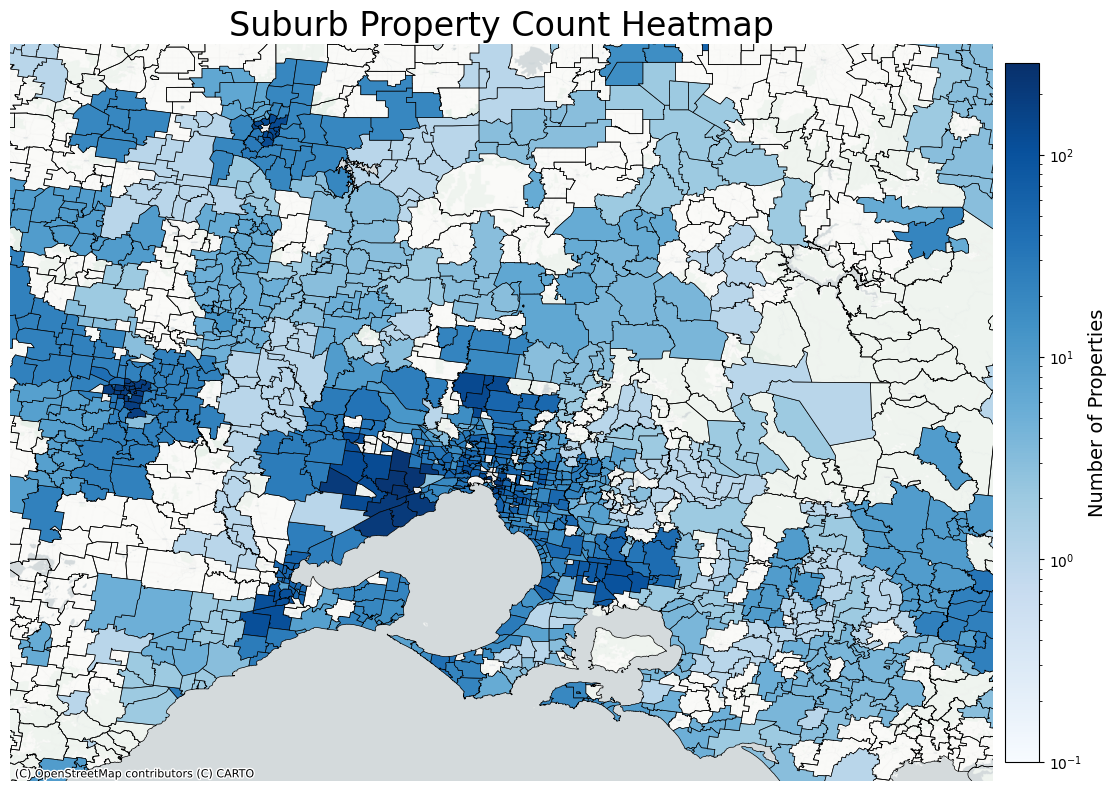

In [21]:
# Create a figure and axis with specified size
fig, ax = plt.subplots(figsize=(12, 10))

# Set the x and y axis limits for the plot
ax.set_xlim([143.5, 146.5])
ax.set_ylim([-38.75, -36.5])

# Adjust the subplot parameters to give some padding
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8)

# Set the minimum and maximum values for the color normalization
vmin, vmax = 0.1, suburbs_gdf['property_count'].max()
# Choose a colormap for the plot
cmap = 'Blues'
# Use a logarithmic normalization for the color scale
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# Plot the GeoDataFrame with property counts, using the specified colormap and normalization
ax = suburbs_gdf.plot(column='property_count', linewidth=0.5, edgecolor='black', 
                      cmap=cmap, legend=False, ax=ax, norm=norm)

# Add a basemap to the plot using the specified coordinate reference system and zoom level
# Sometimes have problems with CartoDB name resolution, try running it again please.
ctx.add_basemap(ax, crs=suburbs_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12) 

# Set the title of the plot
ax.set_title('Suburb Property Count Heatmap', fontsize=24)

# Remove the axis for a cleaner look
ax.set_axis_off()

# Add a colorbar to the plot to indicate the number of properties
patch_col = ax.collections[0]
cb = fig.colorbar(patch_col, ax=ax, shrink=0.72, orientation="vertical", pad=0.01)
cb.ax.set_ylabel('Number of Properties', fontsize=14)

# Adjust the layout to fit everything nicely
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('../../plots/property_count_heatmap.png')

# Display the plot
plt.show()

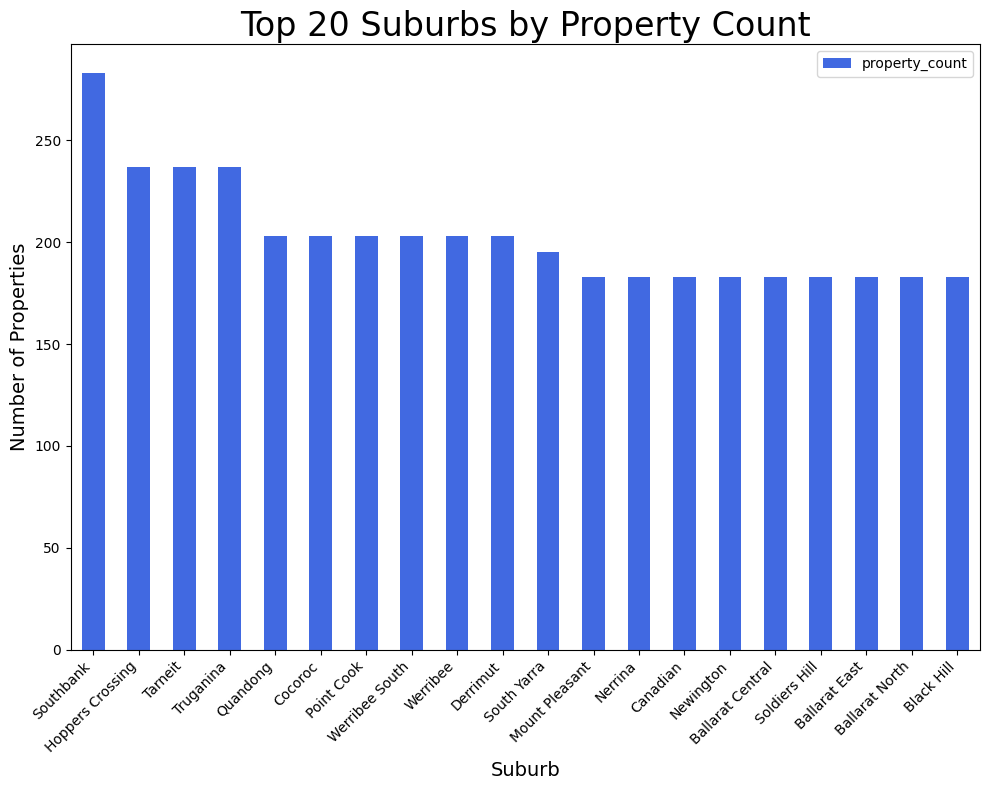

In [ ]:
# Sort the suburbs GeoDataFrame by property count ('property_count') and select top 20 suburbs
top_suburbs = suburbs_gdf[['LOC_NAME', 'property_count']].sort_values(by='property_count', ascending=False).head(20)

# Create a bar plot for the top 20 suburbs
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the top 20 suburbs by property count
top_suburbs.plot(kind='bar', x='LOC_NAME', y='property_count', ax=ax, color='royalblue')

# Set labels and title
ax.set_xlabel('Suburb', fontsize=14)
ax.set_ylabel('Number of Properties', fontsize=14)
ax.set_title('Top 20 Suburbs by Property Count', fontsize=24)

# Rotate the x-axis labels for better readability
ax.set_xticklabels(top_suburbs['LOC_NAME'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.savefig('../../plots/top_20_suburbs_property_count.png')
plt.show()


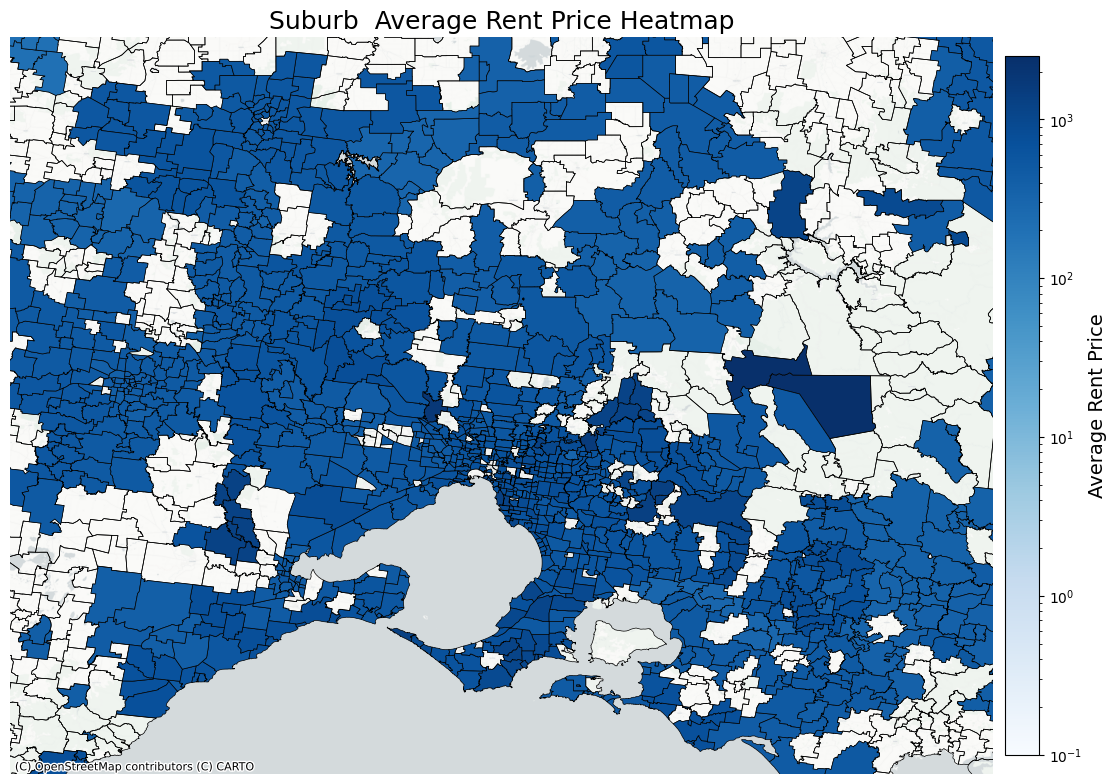

In [8]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 10))

ax.set_xlim([143.5, 146.5])
ax.set_ylim([-38.75, -36.5])

# Adjust the figure layout for better spacing
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8)

# Set minimum and maximum for the color range (without LogNorm)
vmin, vmax = 0.1, suburbs_gdf['avg_price'].max()
cmap = 'Blues'
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# Plot the suburbs data, colored by the 'avg_price' column
ax = suburbs_gdf.plot(column='avg_price', linewidth=0.5, edgecolor='black', 
                      cmap=cmap, legend=False, ax=ax, norm=norm)


# Add the basemap again after setting the limits
ctx.add_basemap(ax, crs=suburbs_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# Set the title of the map
ax.set_title('Suburb  Average Rent Price Heatmap', fontsize=18)

# Remove the axes for a cleaner look
ax.set_axis_off()

# Add a colorbar to show the range of values
patch_col = ax.collections[0]
cb = fig.colorbar(patch_col, ax=ax, shrink=0.72, orientation="vertical", pad=0.01)
cb.ax.set_ylabel('Average Rent Price', fontsize=14)

plt.tight_layout()
plt.savefig('../../plots/property_price_heatmap.png')
plt.show()


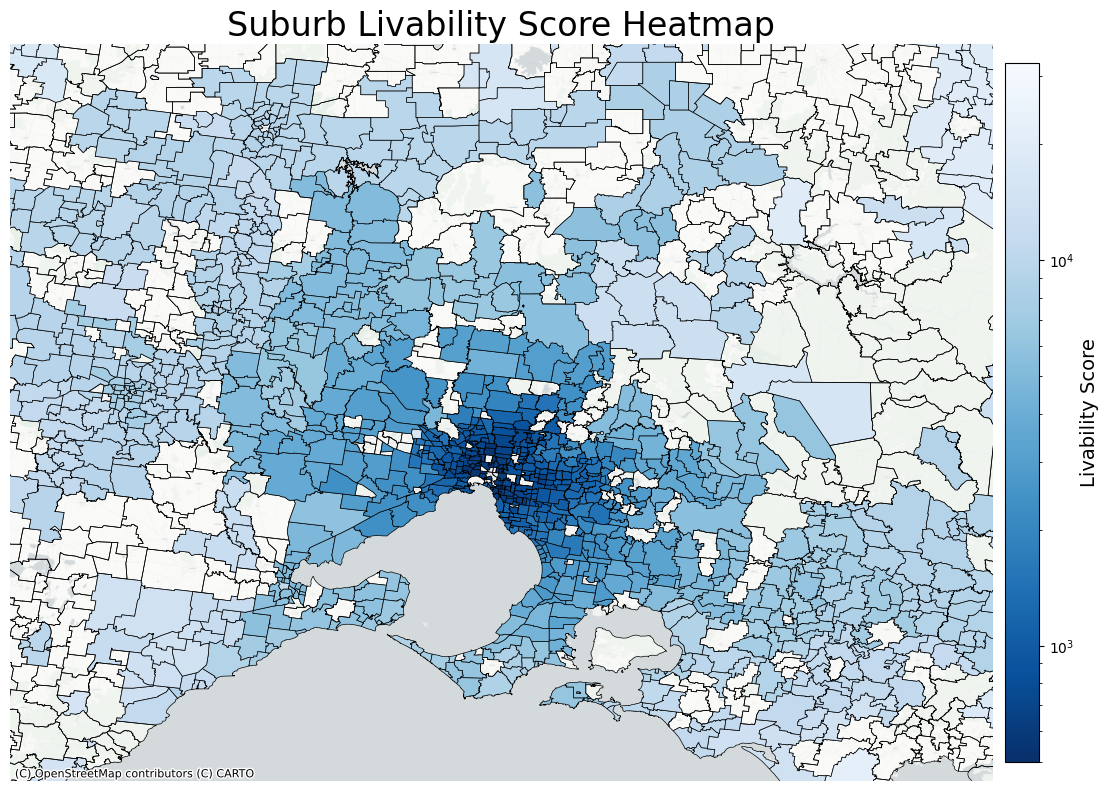

In [9]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 10))

ax.set_xlim([143.5, 146.5])
ax.set_ylim([-38.75, -36.5])

# Adjust the figure layout for better spacing
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8)

# Set minimum and maximum for the color range (without LogNorm)
vmin, vmax = 500, suburbs_gdf['livability_score'].max()
cmap = 'Blues_r'
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# Plot the suburbs data, colored by the 'avg_distance_to_facility' column
ax = suburbs_gdf.plot(column='livability_score', linewidth=0.5, edgecolor='black', 
                      cmap=cmap, legend=False, ax=ax, norm=norm)


# Add the basemap again after setting the limits
ctx.add_basemap(ax, crs=suburbs_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# Set the title of the map
ax.set_title('Suburb Livability Score Heatmap', fontsize=24)

# Remove the axes for a cleaner look
ax.set_axis_off()

# Add a colorbar to show the range of values
patch_col = ax.collections[0]
cb = fig.colorbar(patch_col, ax=ax, shrink=0.72, orientation="vertical", pad=0.01)
cb.ax.set_ylabel('Livability Score', fontsize=14)

plt.tight_layout()
plt.savefig('../../plots/property_livability_score_heatmap.png')
plt.show()

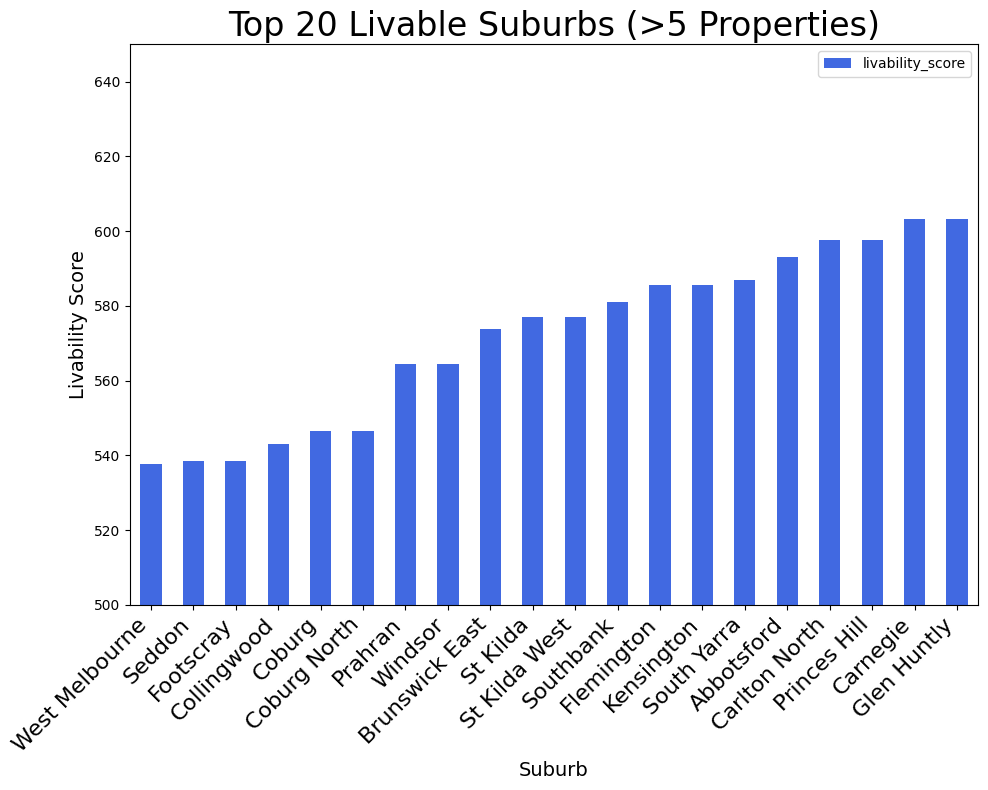

In [10]:
# Filter suburbs that have at least 10 properties, then sort by average price
top_price_suburbs = suburbs_gdf[suburbs_gdf['property_count'] >= 5][['LOC_NAME', 'livability_score']].sort_values(by='livability_score', ascending=True).head(20)

# Create a bar plot for the top 20 suburbs by average price
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the top 20 suburbs by property price
top_price_suburbs.plot(kind='bar', x='LOC_NAME', y='livability_score', ax=ax, color='royalblue')

# Set labels and title
ax.set_xlabel('Suburb', fontsize=14)
ax.set_ylabel('Livability Score', fontsize=14)
ax.set_ylim([500, 650])
ax.set_title('Top 20 Livable Suburbs (>5 Properties)', fontsize=24)

# Rotate the x-axis labels for better readability
ax.set_xticklabels(top_price_suburbs['LOC_NAME'], rotation=45, ha='right', size=16)


# Show the plot
plt.tight_layout()

plt.savefig('../../plots/top_20_suburbs_livability.png')
plt.show()

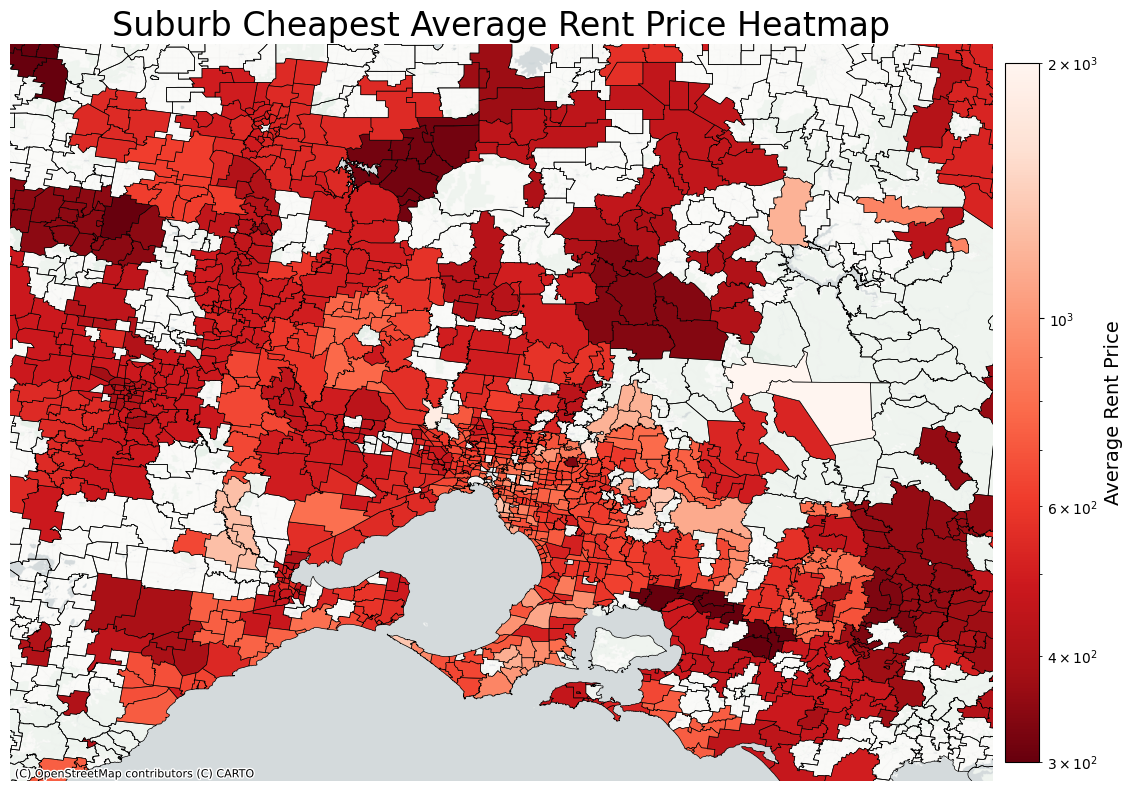

In [11]:
# Calculate the average property price per suburb
# Assuming 'avg_price' is already calculated in 'suburbs_gdf'
# Sort the dataframe by avg_price to highlight the cheapest suburbs
suburbs_gdf = suburbs_gdf.sort_values(by='avg_price', ascending=True)

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Set geographical limits (adjust these to fit your map properly)
ax.set_xlim([143.5, 146.5])
ax.set_ylim([-38.75, -36.5])

# Adjust the figure layout for better spacing
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8)

# Set the color map to 'Reds' to highlight cheapest suburbs
vmin, vmax = 300, 2000  # Keep vmax same to ensure color scaling
cmap = 'Reds_r'  # Change to Reds for highlighting low values
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# Plot the suburbs data, colored by the 'avg_price' column
ax = suburbs_gdf.plot(column='avg_price', linewidth=0.5, edgecolor='black', 
                      cmap=cmap, legend=False, ax=ax, norm=norm)

# Add the basemap again after setting the limits
ctx.add_basemap(ax, crs=suburbs_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# Set the title of the map
ax.set_title('Suburb Cheapest Average Rent Price Heatmap', fontsize=24)

# Remove the axes for a cleaner look
ax.set_axis_off()

# Add a colorbar to show the range of values
patch_col = ax.collections[0]
cb = fig.colorbar(patch_col, ax=ax, shrink=0.72, orientation="vertical", pad=0.01)
cb.ax.set_ylabel('Average Rent Price', fontsize=14)

plt.tight_layout()
plt.savefig('../../plots/reverse_property_price_heatmap.png')

# Display the plot
plt.show()

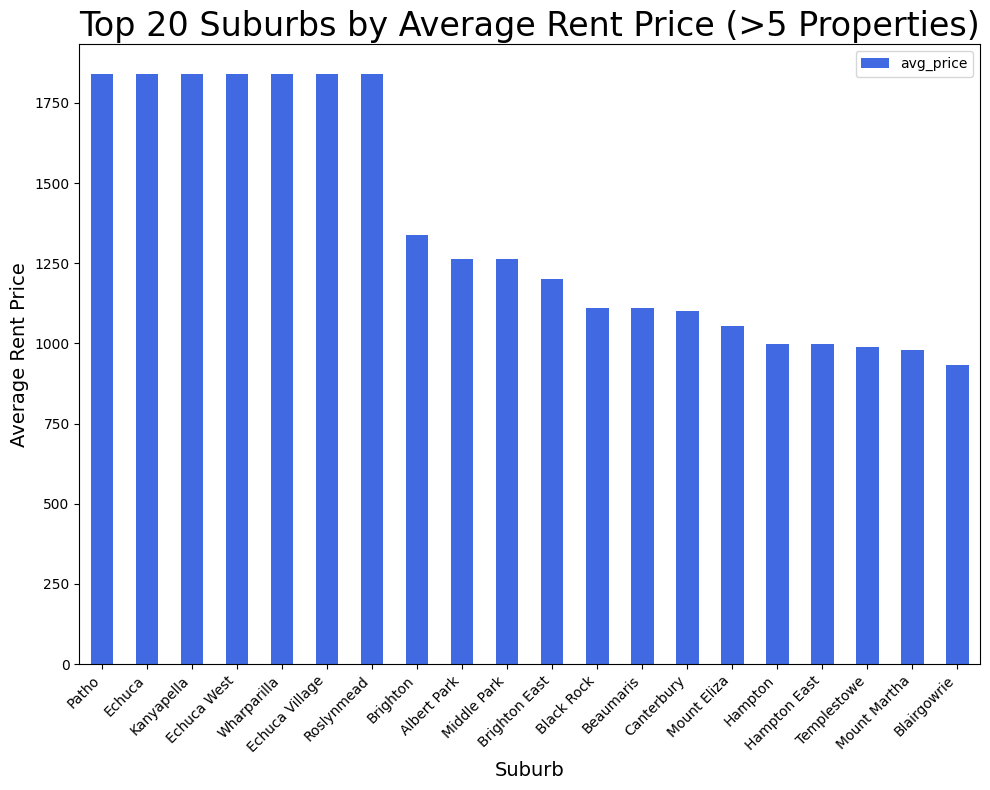

In [12]:
# Filter suburbs that have at least 10 properties, then sort by average price
top_price_suburbs = suburbs_gdf[suburbs_gdf['property_count'] >= 10][['LOC_NAME', 'avg_price']].sort_values(by='avg_price', ascending=False).head(20)

# Create a bar plot for the top 20 suburbs by average price
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the top 20 suburbs by property price
top_price_suburbs.plot(kind='bar', x='LOC_NAME', y='avg_price', ax=ax, color='royalblue')

# Set labels and title
ax.set_xlabel('Suburb', fontsize=14)
ax.set_ylabel('Average Rent Price', fontsize=14)
ax.set_title('Top 20 Suburbs by Average Rent Price (>5 Properties)', fontsize=24)

# Rotate the x-axis labels for better readability
ax.set_xticklabels(top_price_suburbs['LOC_NAME'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.savefig('../../plots/top_20_suburbs_property_price.png')
plt.show()


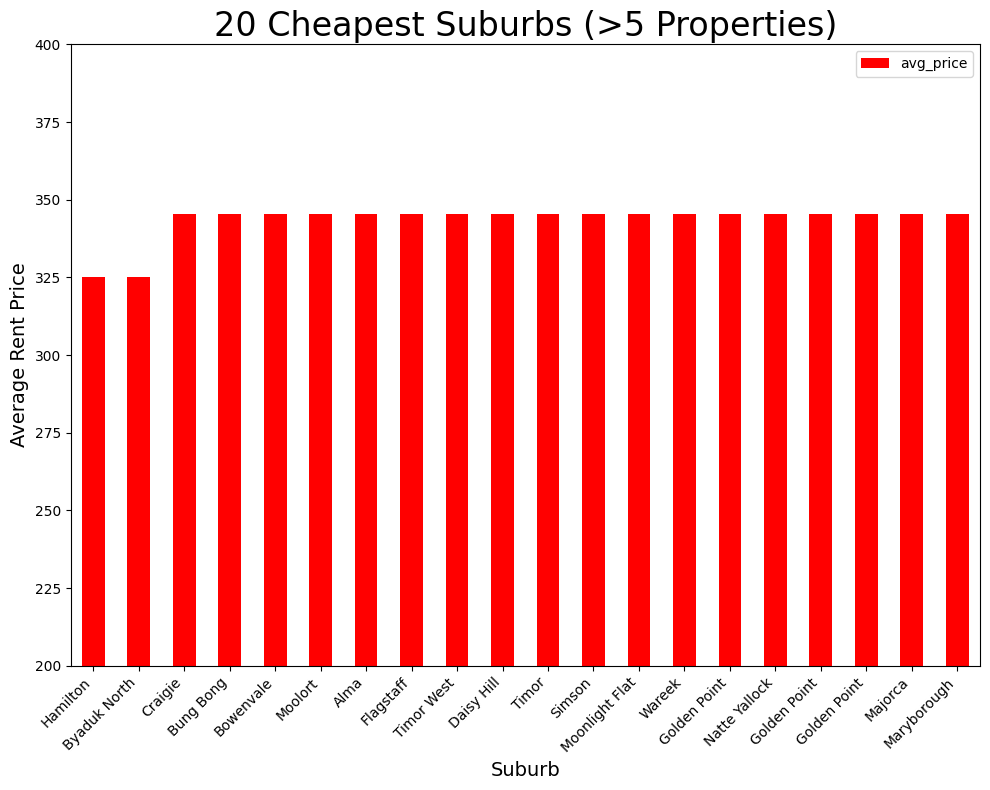

In [13]:
# Filter suburbs that have at least 1 property, then sort by average price (ascending)
bottom_price_suburbs = suburbs_gdf[suburbs_gdf['property_count'] > 5][['LOC_NAME', 'avg_price']].sort_values(by='avg_price', ascending=True).head(20)

# Create a bar plot for the bottom 20 suburbs by average price
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_ylim([200, 400])

# Plot the bottom 20 suburbs by property price
bottom_price_suburbs.plot(kind='bar', x='LOC_NAME', y='avg_price', ax=ax, color='red')

# Set labels and title
ax.set_xlabel('Suburb', fontsize=14)
ax.set_ylabel('Average Rent Price', fontsize=14)
ax.set_title('20 Cheapest Suburbs (>5 Properties)', fontsize=24)

# Rotate the x-axis labels for better readability
ax.set_xticklabels(bottom_price_suburbs['LOC_NAME'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.savefig('../../plots/bottom_20_suburbs_property_price.png')
plt.show()


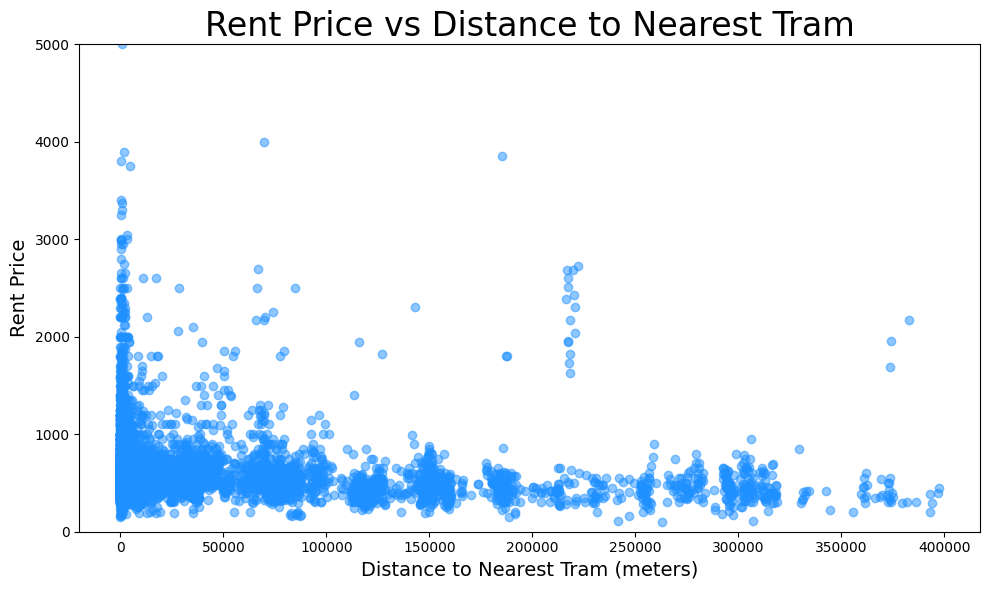

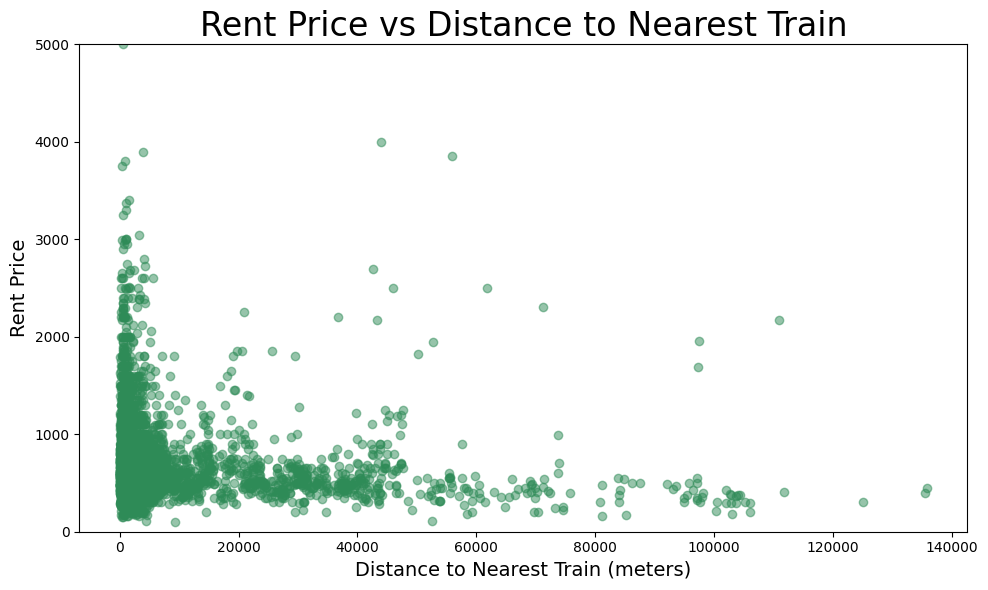

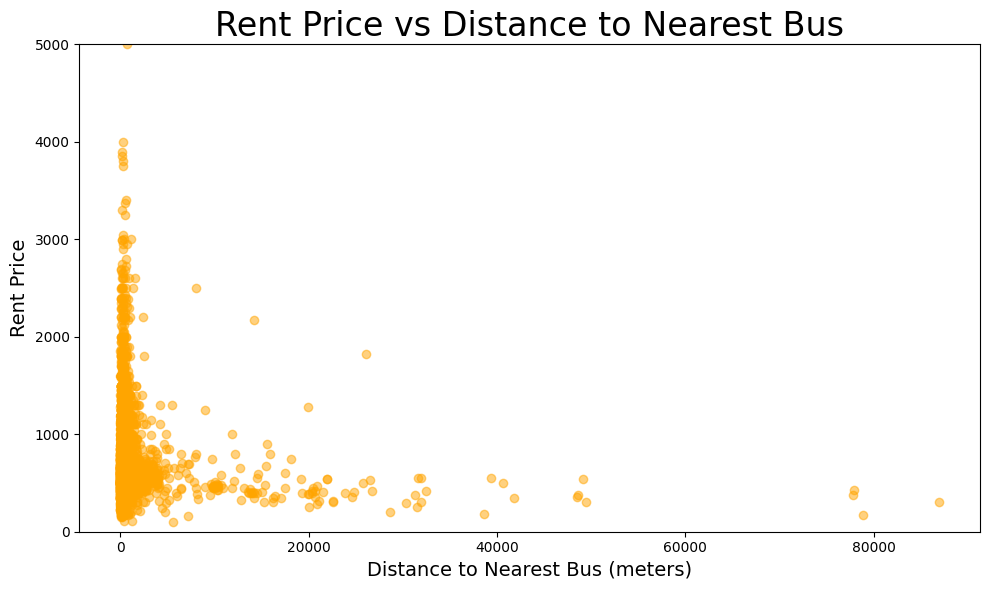

In [14]:
# Scatter plot: Price vs Distance to Tram
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([0, 5000])
ax.scatter(property_df['distance_to_closest_tram'], property_df['price'], alpha=0.5, color='dodgerblue')
ax.set_xlabel('Distance to Nearest Tram (meters)', fontsize=14)
ax.set_ylabel('Rent Price', fontsize=14)
ax.set_title('Rent Price vs Distance to Nearest Tram', fontsize=24)
plt.tight_layout()
plt.savefig('../../plots/price_vs_distance_tram.png')
plt.show()

# Similarly, you can do for Train and Bus
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([0, 5000])
ax.scatter(property_df['distance_to_closest_train'], property_df['price'], alpha=0.5, color='seagreen')
ax.set_xlabel('Distance to Nearest Train (meters)', fontsize=14)
ax.set_ylabel('Rent Price', fontsize=14)
ax.set_title('Rent Price vs Distance to Nearest Train', fontsize=24)
plt.tight_layout()
plt.savefig('../../plots/price_vs_distance_train.png')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([0, 5000])
ax.scatter(property_df['distance_to_closest_bus'], property_df['price'], alpha=0.5, color='orange')
ax.set_xlabel('Distance to Nearest Bus (meters)', fontsize=14)
ax.set_ylabel('Rent Price', fontsize=14)
ax.set_title('Rent Price vs Distance to Nearest Bus', fontsize=24)
plt.tight_layout()
plt.savefig('../../plots/price_vs_distance_bus.png')
plt.show()

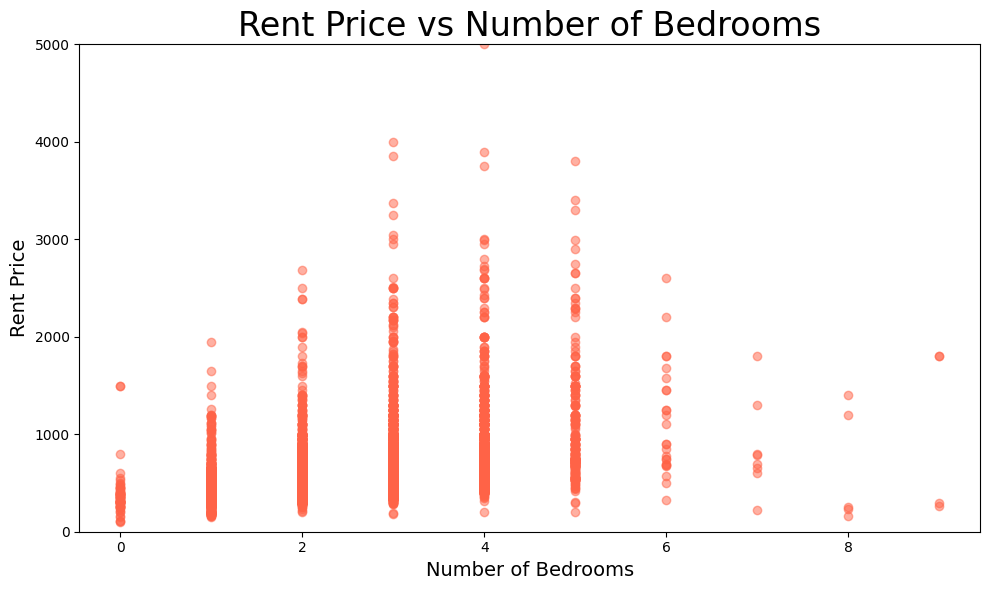

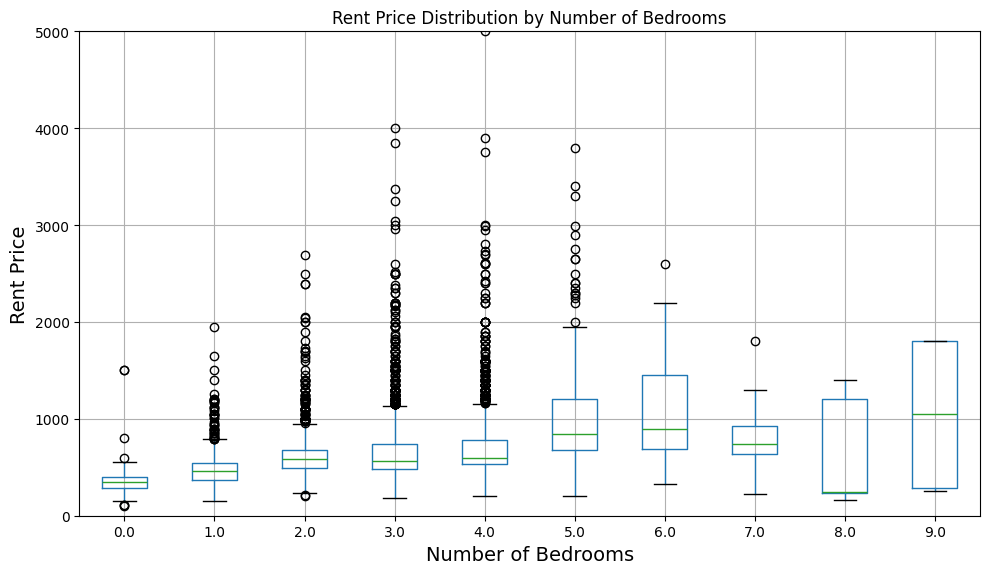

In [15]:
# Scatter plot: Price vs Number of Bedrooms
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([0, 5000])
ax.scatter(property_df['bedrooms'], property_df['price'], alpha=0.5, color='tomato')
ax.set_xlabel('Number of Bedrooms', fontsize=14)
ax.set_ylabel('Rent Price', fontsize=14)
ax.set_title('Rent Price vs Number of Bedrooms', fontsize=24)
plt.tight_layout()
plt.savefig('../../plots/price_vs_bedrooms.png')
plt.show()

# Alternatively, a box plot if you want to summarize price by bedrooms
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([0, 5000])
property_df.boxplot(column='price', by='bedrooms', ax=ax)
ax.set_xlabel('Number of Bedrooms', fontsize=14)
ax.set_ylabel('Rent Price', fontsize=14)
ax.set_title('Rent Price Distribution by Number of Bedrooms')
plt.suptitle('')  # Suppress the automatic title
plt.tight_layout()
plt.savefig('../../plots/price_distribution_by_bedrooms.png')
plt.show()


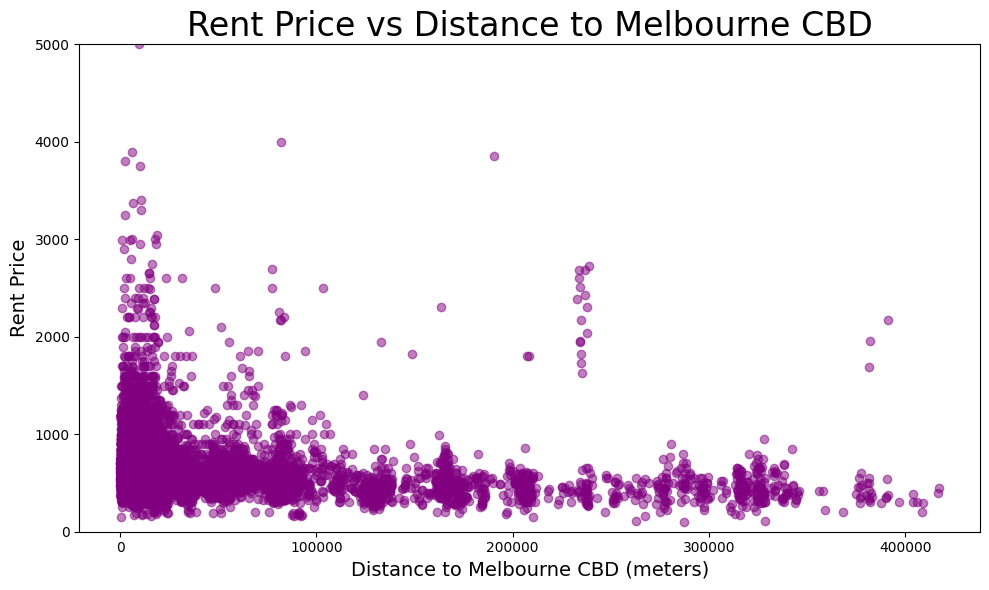

In [16]:
# Scatter plot: Price vs Distance to Melbourne CBD
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim([0, 5000])
ax.scatter(property_df['distance_to_melbourne_cbd'], property_df['price'], alpha=0.5, color='purple')
ax.set_xlabel('Distance to Melbourne CBD (meters)', fontsize=14)
ax.set_ylabel('Rent Price', fontsize=14)
ax.set_title('Rent Price vs Distance to Melbourne CBD', fontsize=24)
plt.tight_layout()
plt.savefig('../../plots/price_vs_distance_melbourne_cbd.png')
plt.show()

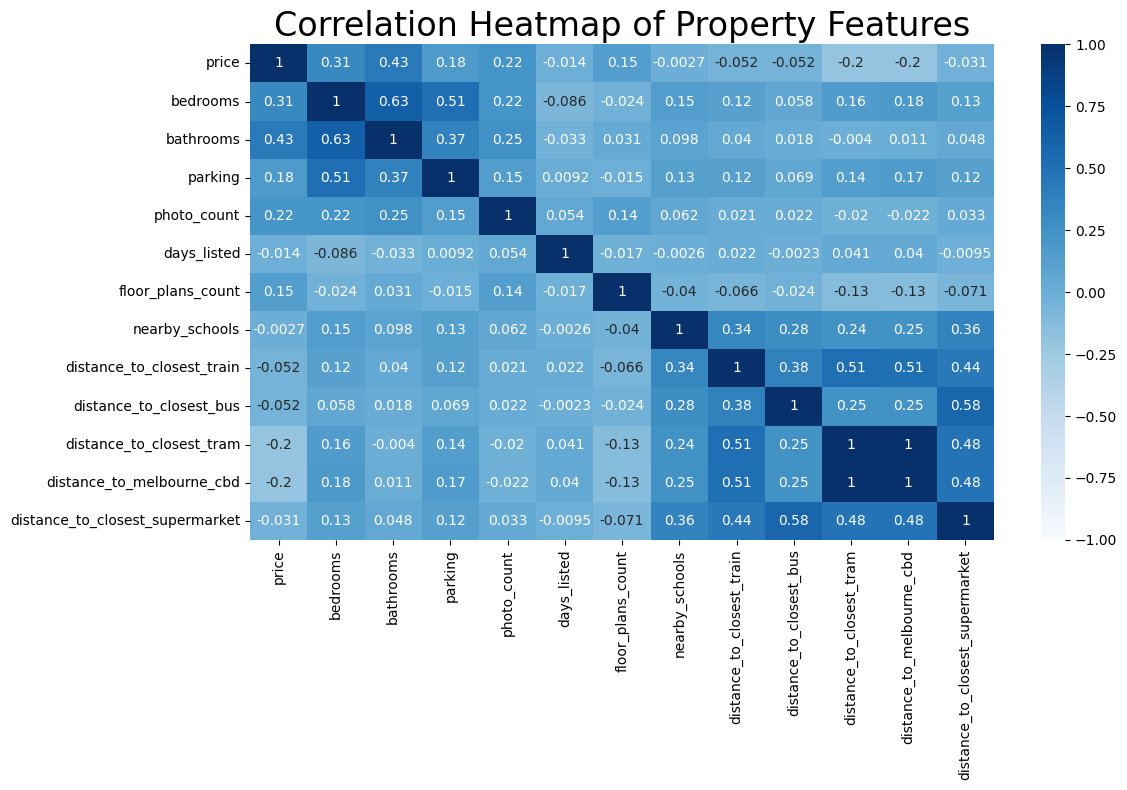

In [17]:
# List of columns to drop from the dataset
columns_to_drop = [
    'title',                # Title of the property listing
    'description',          # Description of the property
    'street_address',       # Street address of the property
    'suburb',               # Suburb where the property is located
    'postcode',             # Postcode of the property's location
    'primary_property_type',# Primary type of the property
    'structured_features',  # Structured features of the property
    'video_count',          # Number of videos available for the property
    'date_listed',          # Date when the property was listed
    'virtual_tour',         # Availability of a virtual tour for the property
    'latitude',             # Latitude coordinate of the property
    'longitude'             # Longitude coordinate of the property
]

# Drop the specified columns from the property DataFrame
numeric_df = property_df.drop(columns=columns_to_drop)

# Calculate the correlation matrix for the numeric DataFrame
corr_matrix = numeric_df.corr()

# Create a figure with specified size
plt.figure(figsize=(12, 8))

# Plot a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1, center=0)

# Set the title of the heatmap
plt.title('Correlation Heatmap of Property Features', fontsize=24)

# Adjust the layout to fit everything nicely
plt.tight_layout()

# Save the heatmap as a PNG file
plt.savefig('../../plots/correlation_heatmap.png')

# Display the heatmap
plt.show()